In [19]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import multiprocessing
import math
import csv

In [20]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    while not bool(slices) or slices[-1][-1] != (file_entries[-1]):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

def to_numpy_helper(files, partitions, index, result):
    data = []
    for i in range(partitions[index][0], partitions[index][2] + 1):
        data.append(files[i].arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=partitions[index][1] if i == partitions[index][0] else None,
                              entry_stop=partitions[index][3] if i == partitions[index][2] else None,
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data)))
    
def to_numpy(path, n_processes):
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))]
    partitions = partition(files, n_processes)
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=to_numpy_helper, args=[files, partitions, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        
    return np.concatenate(tuple(result))

In [4]:
path = "../merged/"

In [7]:
data = to_numpy(path, 64)

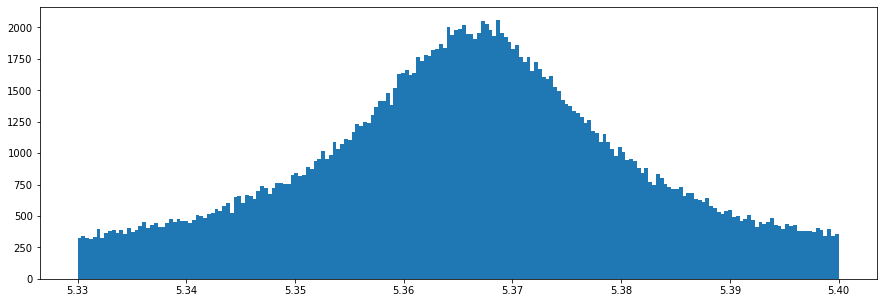

In [8]:
plt.figure(figsize=(15, 5))
plt.hist(data, bins=200)
plt.show()

In [15]:
# start = time.time()
# file = uproot.recreate("tree/mass.root")
# file.mkdir("rootuple")
# file["rootuple/mass"] = {"candidate_vMass" : data}
# time.time() - start

In [16]:
len(data)

189667

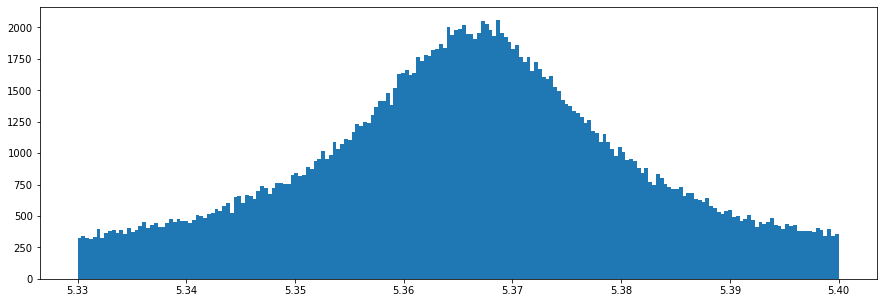

In [22]:
d = to_numpy("../data/32_files/", 40)
plt.figure(figsize=(15, 5))
plt.hist(d, bins=200)
plt.show()

In [23]:
len(d)

189667